In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyspark.sql.functions as funcs
from pyspark.sql.window import Window

In [2]:
%matplotlib inline
mpl.style.use({
    "font.size": 16,
    "figure.figsize": (14, 7),
    "axes.grid": True,
    "axes.autolimit_mode": "data",
    "axes.xmargin": 0,
    "axes.ymargin": 0
})

In [9]:
mwh = spark.read.parquet("/wmf/data/wmf/mediawiki/history/snapshot=2019-04")
ns_map_schema = """
    `hostname` string COMMENT 'Canonical URL for the project, for example ja.wikipedia.org', 
    `dbname` string COMMENT 'Database name for the project, for example jawiki', 
    `namespace` int COMMENT 'for example 0, 100, etc.', 
    `namespace_canonical_name` string COMMENT 'the english prefix if exists, otherwise the localized prefix', 
    `namespace_localized_name` string COMMENT 'the localized prefix', 
    `namespace_is_content` int COMMENT 'Whether this namespace is a content namespace'
"""
ns_map = spark.read.csv(
    "/wmf/data/raw/mediawiki/project_namespace_map/snapshot=2019-04", 
    schema=ns_map_schema
)

In [19]:
join_conds = [
    mwh.wiki_db == ns_map.dbname,
    mwh.page_namespace == ns_map.namespace,
    ns_map.namespace_is_content == 1
]

# new editor content edits (nece)
nece = mwh.where("""
    event_entity = "revision" and
    event_type = "create" and
    event_timestamp between "2018-04" and "2019-04" and
    event_user_registration_timestamp between "2018-04" and "2018-10" and
    datediff(event_timestamp, event_user_registration_timestamp) <= 180
""").join(ns_map, join_conds, how="inner")

In [21]:
w = Window.partitionBy([nece.wiki_db, nece.event_user_text]).orderBy(nece.event_timestamp)

fcel = (
    nece
    .select(
        "wiki_db",
        "event_user_text",
        "event_timestamp",
        "event_user_registration_timestamp",
        funcs.row_number().over(w).alias("content_edit_number")
    )
    .where("content_edit_number = 5")
    .selectExpr(
        "wiki_db",
        "event_user_text",
        "datediff(event_timestamp, event_user_registration_timestamp) as days_to_fifth_content_edit"
    )
).toPandas()

In [27]:
fcel.query("wiki_db == 'enwiki'").sample(10)

,wiki_db,event_user_text,days_to_fifth_content_edit
104160,enwiki,IPittman,1
93556,enwiki,Mosesaaron2000,13
40202,enwiki,Shamgar Mangida,0
38127,enwiki,Thereapers7,0
74591,enwiki,Ladyannu,0
44488,enwiki,Swimmingpiglet,0
16336,enwiki,Kale 4the masses,22
68088,enwiki,Jfuller44,19
126812,enwiki,Jmaxfield18,0
90656,enwiki,Charliehas23,3


In [43]:
fcel["days_to_fifth_content_edit"].describe()

count    140629.00000
mean         18.71742
std          36.87711
min        -139.00000
25%           0.00000
50%           1.00000
75%          16.00000
max         180.00000
Name: days_to_fifth_content_edit, dtype: float64

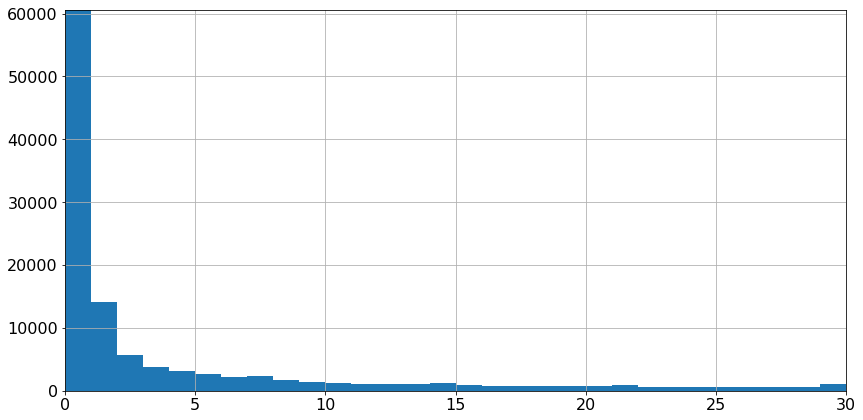

In [42]:
plt.hist(
    fcel["days_to_fifth_content_edit"],
    bins=30,
    range=(0, 30)
);
